<a href="https://colab.research.google.com/github/colaprograms/2019-hackathon-ocr-wymbah/blob/master/notebooks/ctc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains a model!

In [1]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL

In [2]:
import os.path
from os.path import join
def exists(*arg):
    return os.path.exists(join(*arg))
def trymkdir(*arg):
    try:
        os.mkdir(join(*arg))
        print("Created directory", join(*arg))
    except:
        pass

if exists("/content"):
    PATH = "/content"
    print("We're on Google Colab!")
    os.chdir(PATH)
    if not exists(PATH, "AI4Good---Meza-OCR-Challenge"):
      !git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge
    if not exists(PATH, "2019-hackathon-ocr-wymbah"):
      !git clone https://github.com/colaprograms/2019-hackathon-ocr-wymbah
    CODE_PATH = join(PATH, "2019-hackathon-ocr-wymbah")
    "The code may have changed on GitHub since we cloned it"
    !git pull
    
    "Mount Google Drive on /content/gdrive/My Drive and try to save checkpoints in code/checkpoint"
    from google.colab import drive
    drive.mount("/content/gdrive")
    trymkdir("/content/gdrive/My Drive/code")
    trymkdir("/content/gdrive/My Drive/code/checkpoint")
    CHECKPOINT_PATH = "/content/gdrive/My Drive/code/checkpoint"
else:
    print("We're in a Jupyter notebook!")
    if exists("../notebooks"):
        "Move out of the notebooks directory"
        os.chdir("..")
    CODE_PATH = os.getcwd()
    CHECKPOINT_PATH = join(CODE_PATH, "checkpoint")
    trymkdir(CHECKPOINT_PATH)

print("Changing directory to", CODE_PATH)
os.chdir(CODE_PATH)
print("Checkpoints are going to", CHECKPOINT_PATH)

We're in a Jupyter notebook!
Changing directory to /home/gibson/sdb2/cola/ass/balls/2019-hackathon-ocr-wymbah
Checkpoints are going to /home/gibson/sdb2/cola/ass/balls/2019-hackathon-ocr-wymbah/checkpoint


In [3]:
import torch.nn as nn
import torch.optim as optim
import torchvision

# Numpy will show all numbers to 4 decimal places
np.set_printoptions(4, suppress=True)

Reloading util.file


/home/gibson/sdb2/cola/ass/speechify_env/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Using images in ../AI4Good---Meza-OCR-Challenge
Using images in ../AI4Good---Meza-OCR-Challenge

Reloading util.chars

Reloading nets.ctcnet

Loaded 6747 training images and 750 validation images
Showing an example training image

Label: 31
Image mean: [-0. -0. -0.]
Image std dev: [0.5 0.5 0.5]


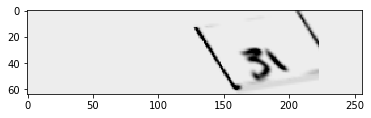

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Showing an example validation image

Label: 6
Image mean: [-0. -0. -0.]
Image std dev: [0.5 0.5 0.5]


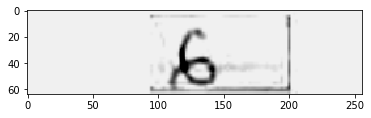

In [4]:
# Reload all of our modules in case they changed

modules_to_reload = [
    "util.file",
    "util.chars",
    "nets.ctcnet"
]

from importlib import import_module, reload
for module in modules_to_reload:
    print("Reloading %s" % module)
    reload(import_module(module))
    print()

from util.chars import chars, nchars, idx, input_to_string
from util.file import FileHolder
from nets.ctcnet import CTCModel

fh = FileHolder()
print("Loaded %d training images and %d validation images" %
     (fh.ntraining(), fh.nvalidation()))

def show(z):
    print()
    b = z[0].numpy().squeeze().transpose(1, 2, 0)
    print("Label:", z[1][0])
    print("Image mean:", np.mean(b, axis=(0, 1)))
    print("Image std dev:", np.std(b, axis=(0, 1)))
    p.imshow(b * 0.3 + 0.9)
    p.show()

print("Showing an example training image")
b = fh.get_batch_tensor(1)
show(b)

print()
print("Showing an example validation image")
b = fh.get_batch_tensor(1, validation=True)
show(b)

In [7]:
BATCH_SIZE = 64

class Runner:
    def __init__(self):
        self.model = CTCModel().cuda()
        self.loss = nn.CTCLoss(reduction='sum').cuda()
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr = 0.0001, # It gets pretty unstable with larger lrs.
            momentum = 0.9,
            nesterov = True, # Everyone loves Nesterov
            weight_decay = 0.001 # A little bit of regularization
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            patience=6,
            verbose=True
        )
        self.trainloss = []
        self.validloss = []
        
    def predict(self, inputs):
        # Enter evaluation mode
        self.model.eval()
        return self.model(inputs.clone().cuda())
    
    def one_batch_loss(self, inputs, outputs):
        inputs = self.model(inputs.clone().cuda())
        inputs = inputs.permute(1, 0, 2)
        # sequence, batch, channels
        # All sequences should be 32 long, because that's
        # the size of the image after we pad to 256 pixels
        # and then run it through the convolutions.
        assert inputs.shape[0] == 32
        input_lengths = torch.tensor(
            [32 for i in range(inputs.shape[1])],
            dtype=torch.int32
        )
        target, target_lengths = Runner.maketarget(outputs)
        
        loss = self.loss(inputs, target, input_lengths, target_lengths)
        return loss
    
    @staticmethod
    def maketarget(outputs):
        classes = []
        "Concatenate all the outputs into one array"
        for string in outputs:
            classes.extend([idx[c] for c in string])
        lengths = [len(string) for string in outputs]
        # We use int32 because Torch promises us that we
        # can use special CuDNN code if we meet some
        # requirements, and one of the requirements is
        # that these tensors have type torch.int32.
        return (
            torch.tensor(classes, dtype=torch.int32),
            torch.tensor(lengths, dtype=torch.int32)
        )

    @staticmethod
    def logits_to_string(logits):
        assert logits.shape[0] == 1
        length = logits.shape[1]
        if isinstance(logits, torch.Tensor):
            logits = logits.clone().detach().cpu().numpy()
        def randchoice(p):
            p = np.exp(p)
            if np.abs(np.sum(p) - 1) > 1e-6:
                raise Exception("logits are not properly normalized")
            u = random.random()
            for i in range(p.shape[0]):
                u -= p[i]
                if u < 1e-6:
                    return i
        def characterat(j):
            return chars[randchoice(logits[0, j, :])]
        return "".join(characterat(j) for j in range(length))
    
    def __train(self, epoch):
        # set training mode just in case it has somehow been unset
        self.model.train()
        running_loss = 0.0
        length = 0
        #print("Example output:")
        import time
        if epoch == 0:
          start = time.time()
        for i in range(100):
          inputs, outputs = fh.get_batch_tensor(BATCH_SIZE)
          self.optimizer.zero_grad()
          loss = self.one_batch_loss(inputs, outputs)
          loss.backward()
          self.optimizer.step()
          running_loss += loss.item()
          length += BATCH_SIZE
          if epoch == 0 and i == 10:
            elapsed = time.time() - start
            print("Each epoch should take about %.1f minutes." % (elapsed*10/60))
            loss = None
        trainingloss = running_loss / length
        print("Epoch %d. Loss: %f" % (epoch, trainingloss))
        self.trainloss.append(trainingloss)
    
    def __valid(self, epoch):
        running_loss = 0.0
        length = 0
        with torch.no_grad():
            for i in range(100):
                inputs, outputs = fh.get_batch_tensor(BATCH_SIZE, validation=True)
                loss = self.one_batch_loss(inputs, outputs)
                running_loss += loss.item()
                length += BATCH_SIZE
        validationloss = running_loss / length
        self.scheduler.step(validationloss)
        print("Validation loss: %f" % validationloss)
        self.validloss.append(validationloss)
        file = "checkpoint/checkpoint-%04d-%.2f" % (epoch, validationloss)
        torch.save({
            'model': self.model.state_dict(),
            'trainloss': self.trainloss,
            'validloss': self.validloss
        }, file)
        print("Saved", file)
    
    def load_from(self, file):
        checkpoint = torch.load(file)
        self.model.load_state_dict(checkpoint['model'])
        self.trainloss, self.validloss = checkpoint['trainloss'], checkpoint['validloss']
        
    def run(self, epochs, resume_checkpoint=None):
        if resume_checkpoint is None:
            print("Training network from scratch")
        else:
            self.load_from(resume_checkpoint)
        for epoch in range(epochs):
            self.__train(epoch)
            self.__valid(epoch)

blade = Runner()
blade.run(100, resume_checkpoint=None)

Training network from scratch
Each epoch should take about 0.7 minutes.
Epoch 0. Loss: 15.485368
Validation loss: 7.799831
Saved checkpoint/checkpoint-0000-7.80
Epoch 1. Loss: 7.725580
Validation loss: 7.581682
Saved checkpoint/checkpoint-0001-7.58
Epoch 2. Loss: 7.390829
Validation loss: 7.069434
Saved checkpoint/checkpoint-0002-7.07
Epoch 3. Loss: 7.082621
Validation loss: 6.910331
Saved checkpoint/checkpoint-0003-6.91
Epoch 4. Loss: 6.747508
Validation loss: 6.147217
Saved checkpoint/checkpoint-0004-6.15
Epoch 5. Loss: 5.914777
Validation loss: 5.647959
Saved checkpoint/checkpoint-0005-5.65
Epoch 6. Loss: 5.379464
Validation loss: 4.928594
Saved checkpoint/checkpoint-0006-4.93


KeyboardInterrupt: 